# Несколько упражнений назад мы хотели посмотреть, есть ли разные шаблоны для пользователей в рабочие дни и выходные. В этом упражнении давайте выясним, есть ли разные шаблоны для пользователей между разными будними днями и между разными часами.

In [3]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


conn = sqlite3.connect('../data/checking-logs.sqlite')

In [4]:
query = """
SELECT timestamp, uid
FROM checker
WHERE uid LIKE 'user_%';
"""

df = pd.read_sql_query(query, conn)

In [5]:
# Преобразование данных
df['weekday_name'] = pd.to_datetime(df['timestamp']).dt.strftime("%a")
df['hour'] = pd.to_datetime(df['timestamp']).dt.hour

# Подсчет коммитов по дням и часам
commit_per_day = pd.DataFrame(df[['uid', 'weekday_name']].value_counts()).reset_index()
commit_per_hour = pd.DataFrame(df[['uid', 'hour']].value_counts()).reset_index()
for_sorting = df.uid.value_counts()

# Сортировка данных
commit_per_day_sorted = commit_per_day.merge(for_sorting,
                                             left_on='uid',
                                             right_index=True,
                                             suffixes=('_day', '_all')).sort_values(by='count_all', ascending=False).set_index('uid')

commit_per_hour_sorted = commit_per_hour.merge(for_sorting,
                                             left_on='uid',
                                             right_index=True,
                                             suffixes=('_hour', '_all')).sort_values(by='count_all', ascending=False).set_index('uid')

In [6]:
# Создание сводных таблиц
pivot_data_day = commit_per_day_sorted.reset_index().pivot_table(index='weekday_name', columns='uid', values='count_day', fill_value=0, sort = False).reindex(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
pivot_data_hour = commit_per_hour_sorted.reset_index().pivot_table(index='hour', columns='uid', values='count_hour', fill_value=0, sort = False).sort_index()

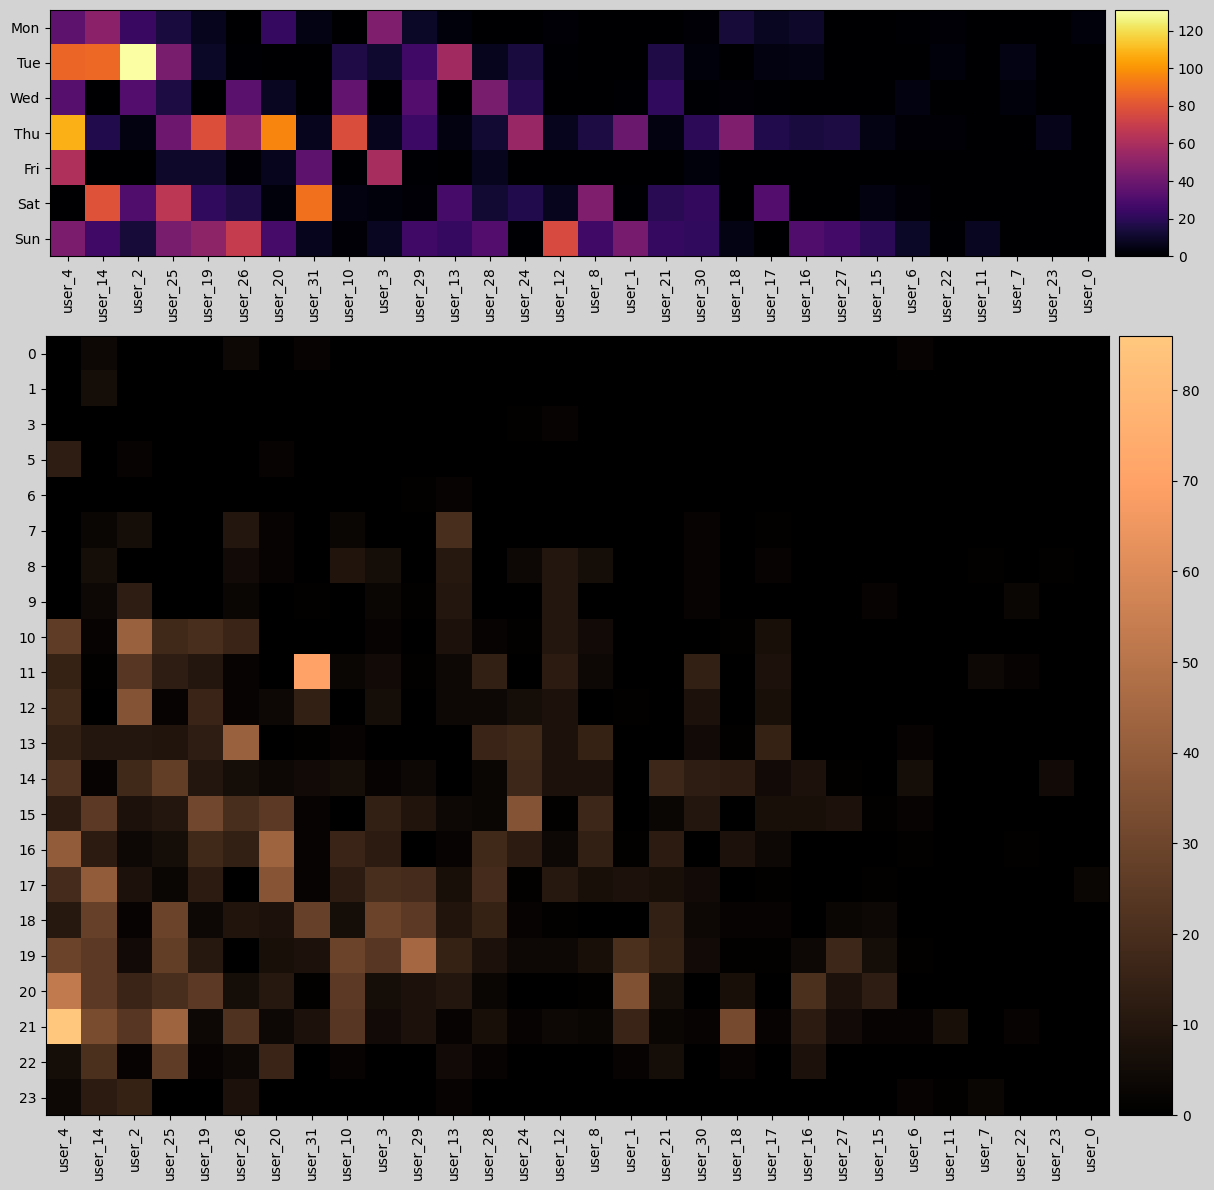

In [7]:
# Функция для создания тепловой карты
def create_heatmap(ax, data, cmap, title=None):
    # Рисуем heatmap
    c = ax.imshow(data, cmap=cmap, interpolation='nearest', aspect='equal')
    return c

# Создание фигуры и осей
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 12), gridspec_kw={'height_ratios': [0.24, 0.76]})
fig.patch.set_facecolor('lightgrey')
ax1.set_facecolor('lightgrey')
ax2.set_facecolor('lightgrey')

# Рисуем и настраиваем первый heatmap (верхний)
c1 = create_heatmap(ax1, pivot_data_day, cmap='inferno')

# Создаем новую ось для цветовой шкалы первого heatmap
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("right", size="5%", pad=0.1)
cbar1 = plt.colorbar(c1, cax=cax1)

# Рисуем и настраиваем второй heatmap (нижний)
c2 = create_heatmap(ax2, pivot_data_hour, cmap='copper')

# Создаем новую ось для цветовой шкалы второго heatmap
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="5%", pad=0.1)
cbar2 = plt.colorbar(c2, cax=cax2)

# Настраиваем оси для первого heatmap
ax1.set_yticks(range(pivot_data_day.shape[0]))  # Устанавливаем позиции делений по оси Y
ax1.set_xticks(range(pivot_data_day.shape[1]))  # Устанавливаем позиции делений по оси X
ax1.set_yticklabels(pivot_data_day.index)  # Устанавливаем метки по оси Y
ax1.set_xticklabels(pivot_data_day.columns, rotation=90)  # Устанавливаем метки по оси X

# Настраиваем оси для второго heatmap
ax2.set_yticks(range(pivot_data_hour.shape[0]))
ax2.set_xticks(range(pivot_data_hour.shape[1])) 
ax2.set_yticklabels(pivot_data_hour.index)  
ax2.set_xticklabels(pivot_data_hour.columns, rotation=90)  

# Настраиваем отображение
plt.tight_layout()  # Убираем лишние пробелы
plt.show()  # Отображаем график

In [14]:
pivot_data_hour.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22 entries, 0 to 23
Data columns (total 30 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   user_4   22 non-null     int64
 1   user_14  22 non-null     int64
 2   user_2   22 non-null     int64
 3   user_25  22 non-null     int64
 4   user_19  22 non-null     int64
 5   user_26  22 non-null     int64
 6   user_20  22 non-null     int64
 7   user_31  22 non-null     int64
 8   user_10  22 non-null     int64
 9   user_3   22 non-null     int64
 10  user_29  22 non-null     int64
 11  user_13  22 non-null     int64
 12  user_28  22 non-null     int64
 13  user_24  22 non-null     int64
 14  user_12  22 non-null     int64
 15  user_8   22 non-null     int64
 16  user_1   22 non-null     int64
 17  user_21  22 non-null     int64
 18  user_30  22 non-null     int64
 19  user_18  22 non-null     int64
 20  user_17  22 non-null     int64
 21  user_16  22 non-null     int64
 22  user_27  22 non-null     int64
 2

In [9]:
max_user_tue = pivot_data_day.loc['Tue'].idxmax()
print(f"У какого пользователя больше всего коммитов во вторник? Ответ: {max_user_tue}")

max_user_thu = pivot_data_day.loc['Thu'].idxmax()
print(f"Какой пользователь имеет больше всего коммитов в четверг? Ответ: {max_user_thu}")

weekdays = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri']
min_commits_day = pivot_data_day.loc[weekdays].sum(axis=1).idxmin()
print(f"В какой будний день пользователи не любят делать много коммитов? Ответ: {min_commits_day}")

max_hour_user = pivot_data_hour.stack().idxmax()
max_hour, max_user = max_hour_user
print(f"Какой пользователь в какой час сделал наибольшее количество коммитов? Ответ: {max_user}, {max_hour}")

У какого пользователя больше всего коммитов во вторник? Ответ: user_2
Какой пользователь имеет больше всего коммитов в четверг? Ответ: user_4
В какой будний день пользователи не любят делать много коммитов? Ответ: Fri
Какой пользователь в какой час сделал наибольшее количество коммитов? Ответ: user_4, 21


In [10]:
conn.close()